Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install "cellpose==2.3.2"
!pip install torch torchvision torchaudio
!pip install omnipose
!pip install "opencv-python-headless<4.3"
exit(0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 10.5 MB/s eta 0:00:00
  Created wheel for omnipose: filename=omnipose-1.0.6-py3-none-any.whl size=345104 sha256=fccf7b68ae4ad9f2208bd412d8f6a1df2e4d7b66ef4bc2f147861a07da46e357
  Stored in directory: /root/.cache/pip/wheels/c1/c1/11/6b60ad9e07f9ac4c6678e493d585aa13c2bd8530

In [ ]:
import numpy as np
import pandas as pd
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import shutil

#from tifffile import imread, imsave

print ("Downloading Models")
from cellpose import models,core

model_list = models.MODEL_NAMES

#Enable Logging
from cellpose.io import logger_setup
logger_setup()

creating new log file


(<Logger cellpose.io (WARNING)>, PosixPath('/root/.cellpose/run.log'))

In [ ]:
import pandas as pd

In [ ]:
import cv2

In [ ]:
metadata = pd.read_csv('/content/gdrive/MyDrive/F2024/Applied Data Science/Project 2/metadata_BR00116991.csv')

downsampled_data_dir = '/content/gdrive/MyDrive/F2024/Applied Data Science/Project 2/downsampled_data'
downsampled_files = os.listdir(downsampled_data_dir)

mask_dir = '/content/gdrive/MyDrive/F2024/Applied Data Science/Project 2/downsampled_data/NewMasks'
mask_files = os.listdir(mask_dir)

In [ ]:
sample_size_per_drug = 9

balanced_sample = metadata.groupby('Metadata_pert_iname', group_keys=False).apply(
    lambda x: x.sample(n=sample_size_per_drug if x.name != 'DMS' else min(sample_size_per_drug, len(x)), replace=False)
)
metadata = balanced_sample.reset_index(drop=True)

<ipython-input-4-b2eb826b1189>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_sample = metadata.groupby('Metadata_pert_iname', group_keys=False).apply(


In [ ]:

condition = metadata['Downsampled_FileName'].isnull()

metadata = metadata[~(condition)]

In [ ]:
metadata.shape

(2233, 19)

In [ ]:
downsampled_mapping = {}

for downsampled_file in downsampled_files:
    common_identifier = downsampled_file[:9]  # Get the first 9 characters
    downsampled_mapping[common_identifier] = downsampled_file

def associate_filenames(row):
    original_identifier = row['FileName_OrigRNA'][:9]  # Get the first 9 characters
    downsampled_file = downsampled_mapping.get(original_identifier, None)  # Returns None if not found
    return pd.Series([downsampled_file, original_identifier])  # Return both downsampled and original identifiers

metadata[['Downsampled_FileName', 'Shortened_OrigRNA']] = metadata.apply(associate_filenames, axis=1)

In [ ]:
metadata.shape

In [ ]:
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

In [ ]:
# Check GPU Access
use_GPU = core.use_gpu()
if not use_GPU:
    print(f"{BOLD}{UNDERLINE}No GPU access detected. Expect slower performance.{END}")
else:
    print(f"{BOLD}{UNDERLINE}GPU access detected. You can proceed.{END}")
    !nvidia-smi

GPU access detected. You can proceed.
Mon Nov  4 20:54:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              25W /  70W |    105MiB / 15360MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------

In [ ]:
# Set Input and Output Directories
input_dir = "/content/gdrive/MyDrive/F2024/Applied Data Science/Project 2/downsampled_data"
save_dir = os.path.join(input_dir, "NewMasks/")

# this is commented out for now becuase i want to keep the same directory
# if os.path.exists(save_dir):
#     print("Existing Mask Directory found. Deleting it.")
#     shutil.rmtree(save_dir)
# os.makedirs(save_dir)

In [ ]:
# Load Image Files

image_format = "tiff"
files = [os.path.join(r, f) for r, _, f in os.walk(input_dir) for f in f if f.endswith(image_format)]
if not files:
    print("No images found. Check if the folder has images.")
else:
    print(f"Number of images loaded: {len(files)}")

Number of images loaded: 2872


Number of images loaded: 2872
r08c17f01_median_aggregated.tiff has 2 dimensions/s


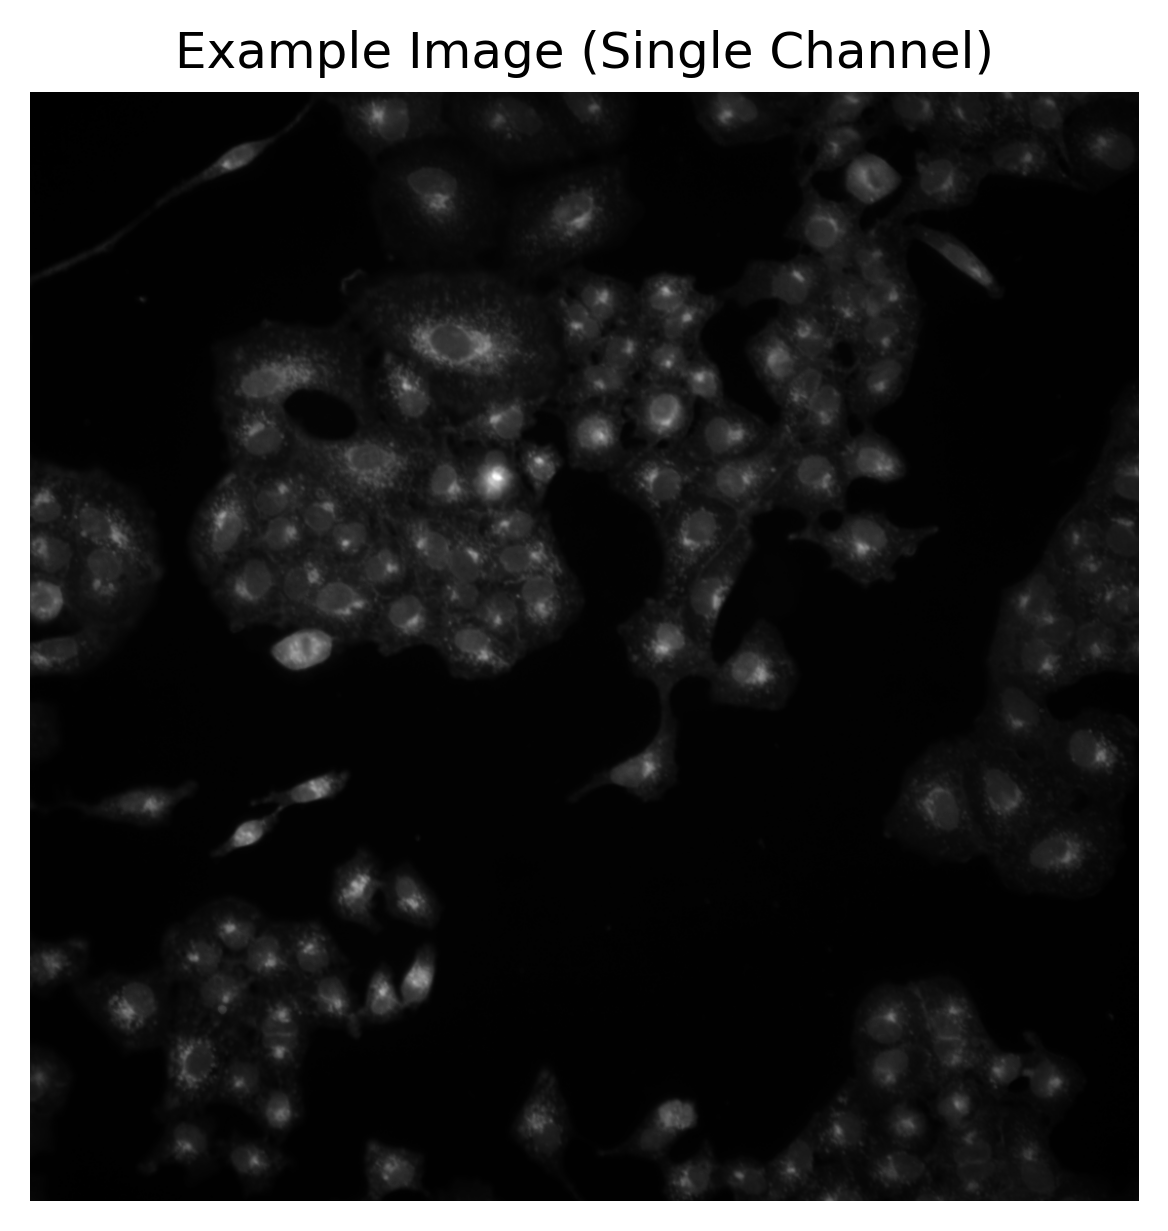

In [ ]:
# Step 5: Read and Load Images
imgs = [skimage.io.imread(f) for f in files]

nimg = len(imgs)
print(f"Number of images loaded: {nimg}")

# Display an Example Image
random_idx = random.choice(range(nimg))
example_image = imgs[random_idx]
n_dim = example_image.ndim

file_name = os.path.basename(files[random_idx])
print(f"{file_name} has {n_dim} dimensions/s")

if n_dim == 3:
    channels = example_image.shape[2]
    fig, axs = plt.subplots(1, channels, figsize=(12, 5))
    for channel in range(channels):
        axs[channel].imshow(example_image[:, :, channel])
        axs[channel].set_title(f'Channel {channel + 1}', size=15)
        axs[channel].axis('off')
    plt.tight_layout()
elif n_dim == 2:
    plt.imshow(example_image, cmap='gray')
    plt.title("Example Image (Single Channel)")
    plt.axis('off')
else:
    print("Unexpected dimensions for image.")

In [ ]:
# Step 6: Choose Cellpose Model
model_type = 'cyto2'  # Default model; adjust if needed
# Initialize Cellpose Model
model = models.CellposeModel(gpu=use_GPU, model_type=model_type, net_avg=True)


100%|██████████| 25.3M/25.3M [00:03<00:00, 8.75MB/s]
100%|██████████| 25.3M/25.3M [00:02<00:00, 9.39MB/s]
100%|██████████| 25.3M/25.3M [00:03<00:00, 8.77MB/s]
100%|██████████| 25.3M/25.3M [00:03<00:00, 8.76MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

In [ ]:
diameter = None  # Set to None to auto-estimate cell size
flow_threshold = 1
cellprob_threshold = -5
segment_channel = 0  # Set to 0 for grayscale images
channels = [segment_channel,0]

Image: r12c17f08_median_aggregated


/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

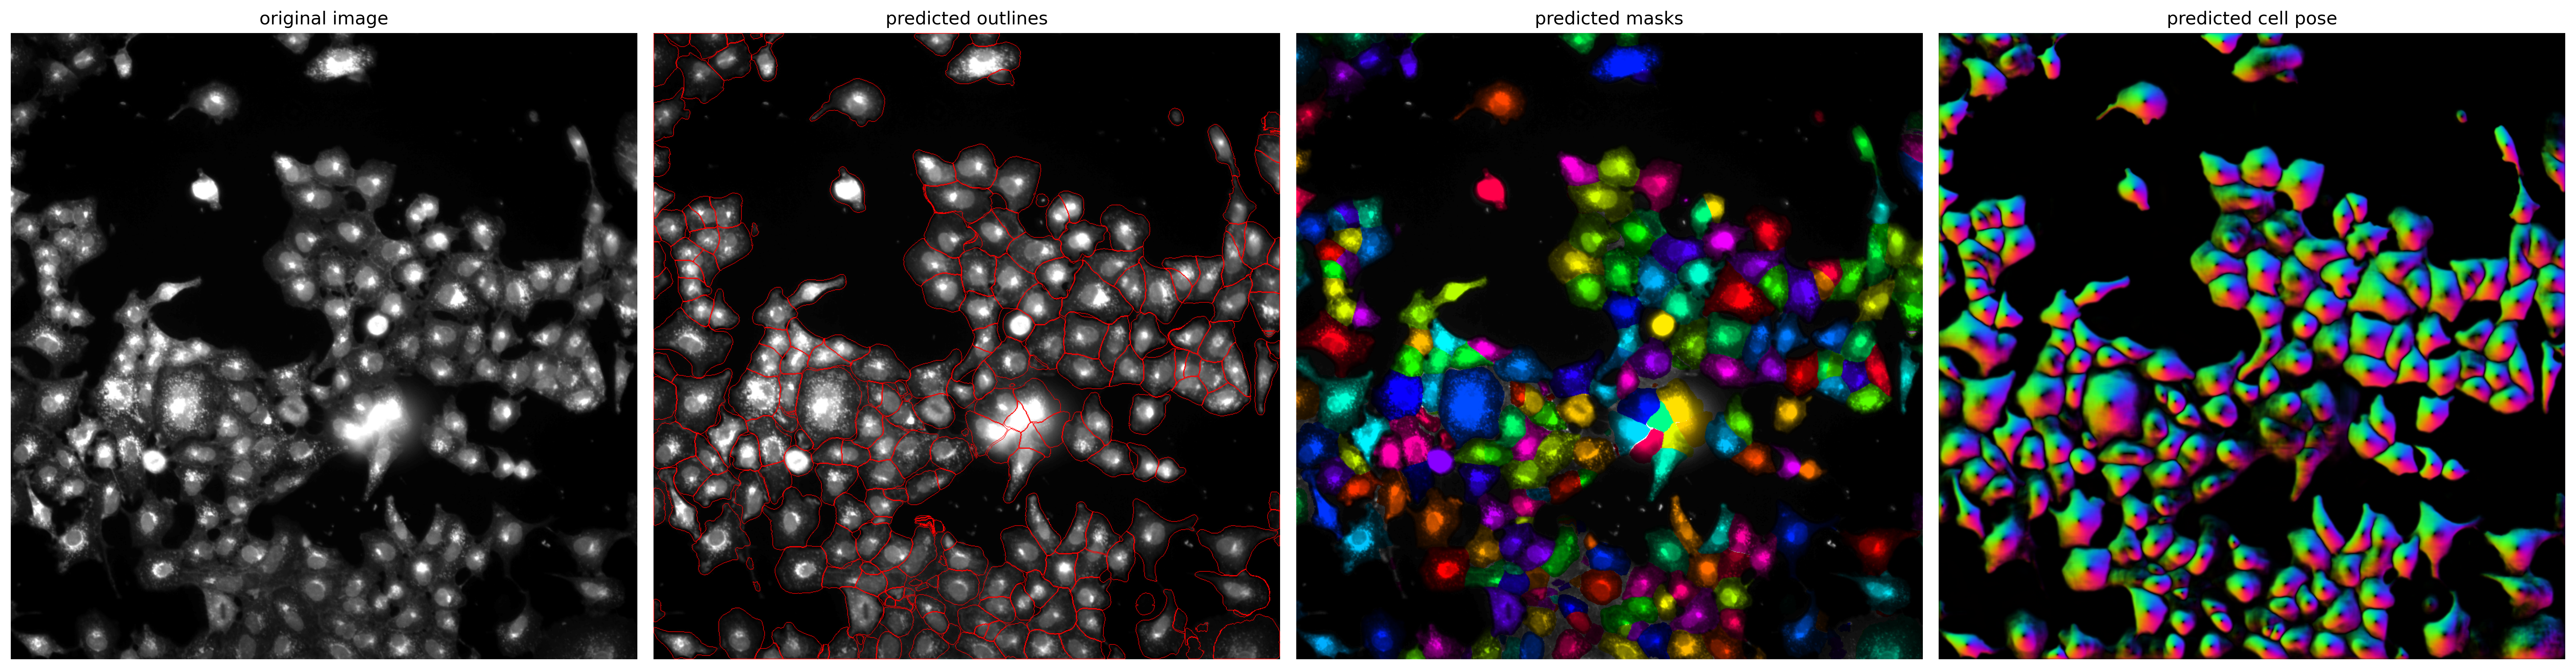

In [ ]:
from skimage.util import img_as_ubyte

Image_Number =  2 # enter a number
Image_Number-=1 #indexing starts at zero
#print(Image_Number)

Diameter = 0
flow_threshold = 1

cellprob_threshold = -5 #min:-6, max:6, step:1


diameter=Diameter
if diameter == 0:
  diameter = None
if Image_Number == -1:
  Image_Number=0
  #print("Image_Number is set to zero, opening first image.")
try:
    image = imgs[Image_Number]
except IndexError as i:
   print("Image number does not exist",i)
   print("Actual no of images in folder: ",len(imgs))
print("Image: %s" %(os.path.splitext(os.path.basename(files[Image_Number]))[0]))
img1=imgs[Image_Number]

import cv2

masks, flows, styles = model.eval(img1, diameter=diameter, flow_threshold=flow_threshold,cellprob_threshold=cellprob_threshold, channels=channels)

# DISPLAY RESULTS
from cellpose import plot
maski = masks
flowi = flows[0]

#convert to 8-bit if not so it can display properly in the graph
if img1.dtype!='uint8':
  img1=img_as_ubyte(img1)

fig = plt.figure(figsize=(24,8))
#if len(img1.shape)==3:
  #img_ch_plot = img1[:,:,segment_channel]img_ch_plot
plot.show_segmentation(fig, img1 , maski, flowi, channels=channels)
plt.tight_layout()
plt.show()

In [ ]:
binary_mask = (maski > 0).astype(np.uint8)

In [ ]:
masked_image = cv2.bitwise_and(img1, img1, mask=binary_mask)

In [ ]:
skimage.io.imsave(mask_dir_path+'test.tiff',masked_image, check_contrast=False)

In [ ]:
mask_dir_path = '/content/gdrive/MyDrive/F2024/Applied Data Science/Project 2/downsampled_data/NewMasks/'
mask_files = os.listdir(mask_dir_path)

In [ ]:
# Running Cellpose on a subset of the folder

Diameter = 0
flow_threshold = 1
cellprob_threshold = -5
channels = [0, 0]  # Replace with the actual channel configuration if needed
save_flow = False
save_dir = "segmented_images/"  # Directory to save segmented images

for img_idx, img in enumerate(imgs):
    file_name = os.path.basename(files[img_idx])

    # Check if file is in the subset list in df
    if file_name not in metadata['Downsampled_FileName'].values:
        print(f"Skipping {file_name} as it's not in the specified subset.")
        continue

    print(f"\nProcessing: {file_name}")

    # Run Cellpose model on the image
    masks, flows, _ = model.eval(img, diameter=Diameter, flow_threshold=flow_threshold,
                                 cellprob_threshold=cellprob_threshold, channels=channels)

    # Convert to 8-bit if needed for proper display
    img = img_as_ubyte(img) if img.dtype != 'uint8' else img
    binary_mask = (masks > 0).astype(np.uint8)

    # Apply the mask to remove the background
    masked_image = cv2.bitwise_and(img, img, mask=binary_mask)
    masked_img = masked_image.astype(np.uint8)

    masked_image_output_name = os.path.join(mask_dir_path, f"masked_{file_name}")
    skimage.io.imsave(masked_image_output_name, masked_img, check_contrast=False)


print("\nSegmentation complete and files saved")









Processing: r12c17f08_median_aggregated.tiff


/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=device)


Streaming output truncated to the last 5000 lines.
Skipping r11c19f02_median_aggregated.tiff as it's not in the specified subset.
Skipping r11c11f03_median_aggregated.tiff as it's not in the specified subset.

Processing: r01c03f05_median_aggregated.tiff

Processing: r10c12f09_median_aggregated.tiff

Processing: r05c01f01_median_aggregated.tiff

Processing: r12c04f02_median_aggregated.tiff

Processing: r02c16f04_median_aggregated.tiff
Skipping r08c04f07_median_aggregated.tiff as it's not in the specified subset.
Skipping r13c01f04_median_aggregated.tiff as it's not in the specified subset.

Processing: r10c22f04_median_aggregated.tiff

Processing: r02c18f09_median_aggregated.tiff

Processing: r13c07f08_median_aggregated.tiff
Skipping r10c14f05_median_aggregated.tiff as it's not in the specified subset.

Processing: r03c13f02_median_aggregated.tiff

Processing: r10c24f08_median_aggregated.tiff

Processing: r07c11f06_median_aggregated.tiff

Processing: r09c01f01_median_aggregated.tiff

P

In [ ]:
metadata.to_csv('/content/gdrive/MyDrive/F2024/Applied Data Science/Project 2/metadata_resampled', index=False)